#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.
 
### CHAPTER 12
**CH12 Returns on a company stock and market returns**

version 1.0 2021-05-31
 
 

In [1]:
import os
import sys
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import pyfixest as pf
from arch.unitroot import PhillipsPerron
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from mizani.formatters import percent_format
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

warnings.filterwarnings("ignore")


In [2]:
current_path = os.getcwd()
base_dir = current_path.split("da_case_studies")[0]
data_in = os.path.join(str(base_dir), "da_data_repo/stocks-sp500/raw/")
data_out = os.path.join(str(base_dir), "da_data_repo/stocks-sp500/clean/")
output = os.path.join(str(base_dir), "da_case_studies/ch12-stock-returns-risk/output/")
func = os.path.join(str(base_dir), "da_case_studies/ch00-tech-prep/")
sys.path.append(func)


In [3]:
import py_helper_functions as da
sns.set_theme(rc=da.da_theme, palette=da.color)

In [4]:
stock_data = pd.read_csv(os.path.join(data_in, "ready_sp500_45_cos.csv"))
#stock_data = pd.read_csv("https://osf.io/download/4pgrf/")



In [5]:
stock_data.head()


,ticker,ref.date,price.open,price.close,price.adjusted,price.low,price.high,volume
0,ACN,2001-07-19,15.10,15.17,11.497672,15.00,15.29,34994300.0
1,ACN,2001-07-20,15.05,15.01,11.376402,14.80,15.05,9238500.0
2,ACN,2001-07-23,15.00,15.00,11.368821,14.55,15.01,7501000.0
3,ACN,2001-07-24,14.95,14.86,11.262713,14.70,14.97,3537300.0
4,ACN,2001-07-25,14.70,14.95,11.330926,14.65,14.95,4208100.0


In [6]:
MSFT = stock_data[stock_data["ticker"] == "MSFT"]


In [7]:
p_MSFT = (
    MSFT[["ref.date", "price.close"]]
    .rename(columns={"ref.date": "date"})
    .reset_index(drop=True)
)


In [8]:
p_MSFT["date"] = pd.to_datetime(p_MSFT["date"])


In [9]:
p_MSFT.head()


,date,price.close
0,1997-12-29,15.789063
1,1997-12-30,16.281250
2,1997-12-31,16.156250
3,1998-01-02,16.390625
4,1998-01-05,16.296875


In [10]:
sp500_index = pd.read_csv(os.path.join(data_in, "ready_sp500_index.csv"))


In [11]:
p_SP500 = (
    sp500_index[["ref.date", "price.close"]]
    .rename(columns={"ref.date": "date"})
    .reset_index(drop=True)
)


In [12]:
p_SP500["date"] = pd.to_datetime(p_SP500["date"])


In [13]:
data_daily = (
    pd.merge(p_SP500, p_MSFT, how="inner", on="date")
    .rename(columns={"price.close_x": "p_SP500", "price.close_y": "p_MSFT"})
    .reset_index(drop=True)
)


In [14]:
data_daily = data_daily[
    (data_daily["date"] >= "1997-12-31") & (data_daily["date"] <= "2018-12-31")
]


In [15]:
data_daily["year"] = data_daily["date"].dt.year


In [16]:
data_daily["month"] = data_daily["date"].dt.month


In [17]:
# data_daily.to_csv(os.path.join(data_out,"stock-prices-daily.csv"))


# PART I: Graphs


In [18]:
data_daily["lnp_MSFT"] = data_daily["p_MSFT"].map(lambda x: np.log(x))


In [19]:
data_daily["lnp_SP500"] = data_daily["p_SP500"].map(lambda x: np.log(x))


In [20]:
limits = datetime(1998, 1, 1), datetime(2018, 1, 1)


In [21]:

breaks_sns = [
    "1998-01-01", "2002-01-01", "2006-01-01",
    "2010-01-01", "2014-01-01", "2018-01-01"
]

### Figure 12.2 Stock prices, daily time series

For time series data, plotnine wants the index to start from 0

In [22]:
data_daily = data_daily.reset_index(drop=True)

(a) Microsoft

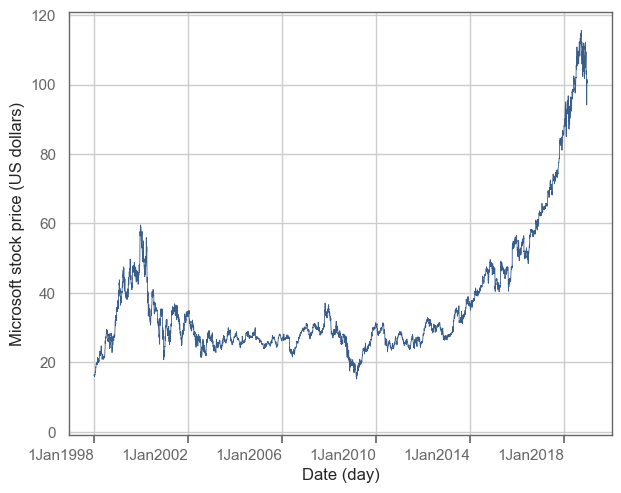

In [23]:
sns.lineplot(data=data_daily, x="date", y="p_MSFT", linewidth=0.6)

plt.xlabel("Date (day)")
plt.ylabel("Microsoft stock price (US dollars)")

plt.xticks(breaks_sns, [pd.to_datetime(d).strftime("1%b%Y") for d in breaks_sns], ha="right")
plt.ylim(-1,121)
plt.yticks(ticks=np.arange(0,121, 20))  
plt.show()

(b) S&P500 index

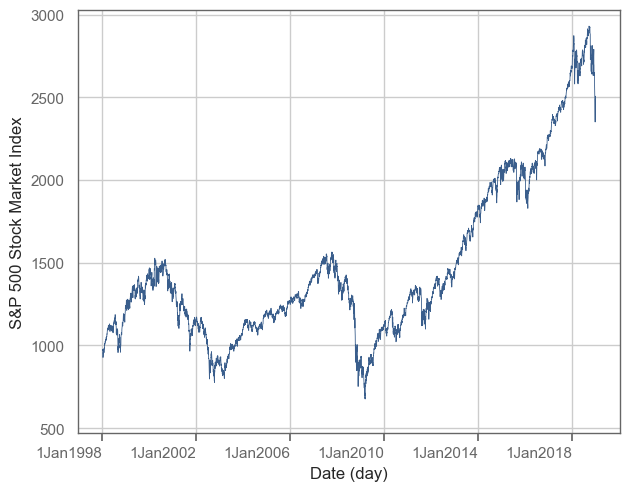

In [24]:
sns.lineplot(data=data_daily, x="date", y="p_SP500", linewidth=0.6)

plt.xlabel("Date (day)")
plt.ylabel("S&P 500 Stock Market Index")

plt.xticks(breaks_sns, [pd.to_datetime(d).strftime("1%b%Y") for d in breaks_sns], ha="right")
plt.ylim(470,3030)
plt.yticks(ticks=np.arange(500,3001, 500))  
plt.show()

In [25]:
print(PhillipsPerron(data_daily["p_MSFT"], lags=32, test_type="rho", trend="n"))
print(PhillipsPerron(data_daily["p_MSFT"], lags=32, test_type="rho", trend="c"))
print(PhillipsPerron(data_daily["p_MSFT"], lags=32, test_type="rho", trend="ct"))


     Phillips-Perron Test (Z-rho)    
Test Statistic                  2.287
P-value                         0.994
Lags                               32
-------------------------------------

Trend: No Trend
Critical Values: -13.24 (1%), -7.79 (5%), -5.54 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic                  2.245
P-value                         0.998
Lags                               32
-------------------------------------

Trend: Constant
Critical Values: -20.60 (1%), -14.08 (5%), -11.24 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic                 -0.092
P-value                         0.995
Lags                               32
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -29.31 (1%),

In [26]:
print(PhillipsPerron(data_daily["p_SP500"], lags=32, test_type="rho", trend="n"))
print(PhillipsPerron(data_daily["p_SP500"], lags=32, test_type="rho", trend="c"))
print(PhillipsPerron(data_daily["p_SP500"], lags=32, test_type="rho", trend="ct"))


     Phillips-Perron Test (Z-rho)    
Test Statistic                  0.908
P-value                         0.892
Lags                               32
-------------------------------------

Trend: No Trend
Critical Values: -13.24 (1%), -7.79 (5%), -5.54 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic                 -0.292
P-value                         0.940
Lags                               32
-------------------------------------

Trend: Constant
Critical Values: -20.60 (1%), -14.08 (5%), -11.24 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic                 -3.943
P-value                         0.894
Lags                               32
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -29.31 (1%),

In [27]:
data_daily["l.p_MSFT"] = data_daily["p_MSFT"].shift()
data_daily["l.p_SP500"] = data_daily["p_SP500"].shift()
data_daily["d.p_MSFT"] = data_daily["p_MSFT"] - data_daily["l.p_MSFT"]
data_daily["d.p_SP500"] = data_daily["p_SP500"] - data_daily["l.p_SP500"]
data_daily["PctRetMSFT"] = data_daily["d.p_MSFT"] / data_daily["l.p_MSFT"] * 100
data_daily["PctRetSP500"] = data_daily["d.p_SP500"] / data_daily["l.p_SP500"] * 100


In [28]:
data_daily["d.lnp_MSFT"] = np.log(data_daily["p_MSFT"]) - np.log(
    data_daily["p_MSFT"].shift()
)
data_daily["d.lnp_SP500"] = np.log(data_daily["p_SP500"]) - np.log(
    data_daily["p_SP500"].shift()
)


In [29]:
data_monthly = (
    data_daily[["date", "year", "month", "p_SP500", "p_MSFT"]]
    .groupby(data_daily["date"].dt.to_period("M"))
    .last()
    .reset_index(drop=True)
)


In [30]:
data_monthly


,date,year,month,p_SP500,p_MSFT
0,1997-12-31,1997,12,970.429993,16.156250
1,1998-01-30,1998,1,980.280029,18.648438
2,1998-02-27,1998,2,1049.339966,21.187500
3,1998-03-31,1998,3,1101.750000,22.375000
4,1998-04-30,1998,4,1111.750000,22.531250
...,...,...,...,...,...
248,2018-08-31,2018,8,2901.520020,112.330002
249,2018-09-28,2018,9,2913.979980,114.370003
250,2018-10-31,2018,10,2711.739990,106.809998
251,2018-11-30,2018,11,2760.169922,110.889999


In [31]:
data_monthly["l.p_MSFT"] = data_monthly["p_MSFT"].shift()
data_monthly["l.p_SP500"] = data_monthly["p_SP500"].shift()
data_monthly["d.p_MSFT"] = data_monthly["p_MSFT"] - data_monthly["l.p_MSFT"]
data_monthly["d.p_SP500"] = data_monthly["p_SP500"] - data_monthly["l.p_SP500"]
data_monthly["PctRetMSFT"] = data_monthly["d.p_MSFT"] / data_monthly["l.p_MSFT"] * 100
data_monthly["PctRetSP500"] = (
    data_monthly["d.p_SP500"] / data_monthly["l.p_SP500"] * 100
)


In [32]:
data_monthly["d.lnp_MSFT"] = np.log(data_monthly["p_MSFT"]) - np.log(
    data_monthly["p_MSFT"].shift()
)
data_monthly["d.lnp_SP500"] = np.log(data_monthly["p_SP500"]) - np.log(
    data_monthly["p_SP500"].shift()
)


In [33]:
data_daily.head()


,date,p_SP500,p_MSFT,year,month,lnp_MSFT,lnp_SP500,l.p_MSFT,l.p_SP500,d.p_MSFT,d.p_SP500,PctRetMSFT,PctRetSP500,d.lnp_MSFT,d.lnp_SP500
0,1997-12-31,970.429993,16.156250,1997,12,2.782307,6.877739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1998-01-02,975.039978,16.390625,1998,1,2.796710,6.882478,16.156250,970.429993,0.234375,4.609985,1.450677,0.475046,0.014403,0.004739
2,1998-01-05,977.070007,16.296875,1998,1,2.790973,6.884558,16.390625,975.039978,-0.093750,2.030029,-0.571973,0.208200,-0.005736,0.002080
3,1998-01-06,966.580017,16.390625,1998,1,2.796710,6.873764,16.296875,977.070007,0.093750,-10.489990,0.575264,-1.073617,0.005736,-0.010794
4,1998-01-07,964.000000,16.195313,1998,1,2.784722,6.871091,16.390625,966.580017,-0.195312,-2.580017,-1.191608,-0.266922,-0.011988,-0.002673


In [34]:
data_monthly.head()


,date,year,month,p_SP500,p_MSFT,l.p_MSFT,l.p_SP500,d.p_MSFT,d.p_SP500,PctRetMSFT,PctRetSP500,d.lnp_MSFT,d.lnp_SP500
0,1997-12-31,1997,12,970.429993,16.156250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1998-01-30,1998,1,980.280029,18.648438,16.156250,970.429993,2.492188,9.850036,15.425535,1.015018,0.143455,0.010099
2,1998-02-27,1998,2,1049.339966,21.187500,18.648438,980.280029,2.539062,69.059937,13.615414,7.044919,0.127649,0.068078
3,1998-03-31,1998,3,1101.750000,22.375000,21.187500,1049.339966,1.187500,52.410034,5.604720,4.994571,0.054533,0.048738
4,1998-04-30,1998,4,1111.750000,22.531250,22.375000,1101.750000,0.156250,10.000000,0.698324,0.907647,0.006959,0.009036


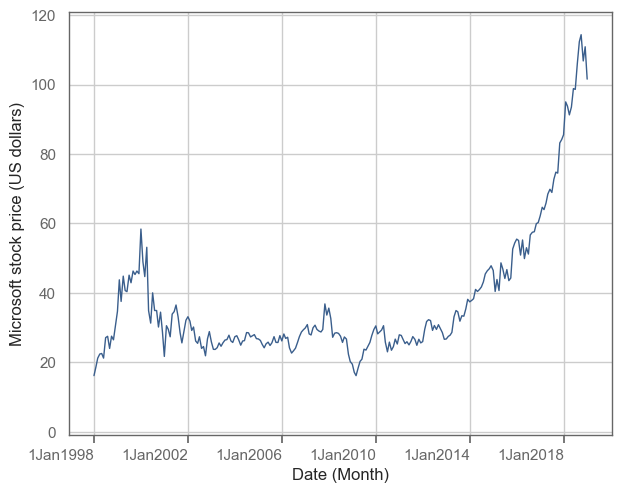

In [35]:
sns.lineplot(data=data_monthly, x="date", y="p_MSFT", linewidth=1)

plt.xlabel("Date (Month)")
plt.ylabel("Microsoft stock price (US dollars)")

plt.xticks(breaks_sns, [pd.to_datetime(d).strftime("1%b%Y") for d in breaks_sns], ha="right")
plt.ylim(-1,121)
plt.yticks(ticks=np.arange(0,121, 20))  
plt.show()

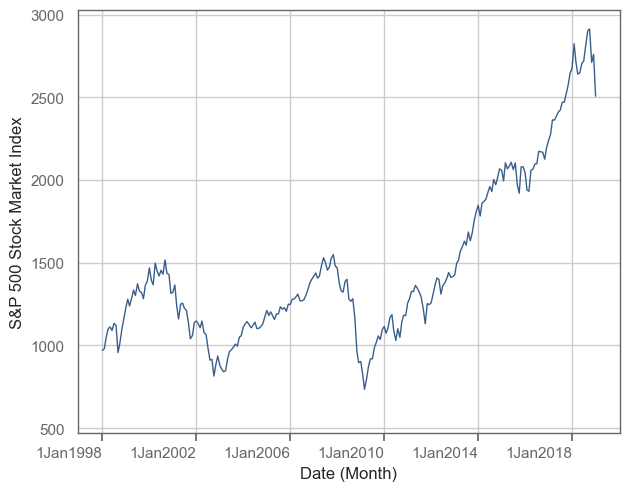

In [36]:
sns.lineplot(data=data_monthly, x="date", y="p_SP500", linewidth=1)

plt.xlabel("Date (Month)")
plt.ylabel("S&P 500 Stock Market Index")

plt.xticks(breaks_sns, [pd.to_datetime(d).strftime("1%b%Y") for d in breaks_sns], ha="right")
plt.ylim(470,3030)
plt.yticks(ticks=np.arange(500,3001, 500))  
plt.show()

In [37]:
print(PhillipsPerron(data_daily["p_MSFT"], lags=32, test_type="rho", trend="n"))
print(PhillipsPerron(data_daily["p_MSFT"], lags=32, test_type="rho", trend="c"))
print(PhillipsPerron(data_daily["p_MSFT"], lags=32, test_type="rho", trend="ct"))


     Phillips-Perron Test (Z-rho)    
Test Statistic                  2.287
P-value                         0.994
Lags                               32
-------------------------------------

Trend: No Trend
Critical Values: -13.24 (1%), -7.79 (5%), -5.54 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic                  2.245
P-value                         0.998
Lags                               32
-------------------------------------

Trend: Constant
Critical Values: -20.60 (1%), -14.08 (5%), -11.24 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic                 -0.092
P-value                         0.995
Lags                               32
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -29.31 (1%),

In [38]:
print(PhillipsPerron(data_daily["p_SP500"], lags=32, test_type="rho", trend="n"))
print(PhillipsPerron(data_daily["p_SP500"], lags=32, test_type="rho", trend="c"))
print(PhillipsPerron(data_daily["p_SP500"], lags=32, test_type="rho", trend="ct"))


     Phillips-Perron Test (Z-rho)    
Test Statistic                  0.908
P-value                         0.892
Lags                               32
-------------------------------------

Trend: No Trend
Critical Values: -13.24 (1%), -7.79 (5%), -5.54 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic                 -0.292
P-value                         0.940
Lags                               32
-------------------------------------

Trend: Constant
Critical Values: -20.60 (1%), -14.08 (5%), -11.24 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic                 -3.943
P-value                         0.894
Lags                               32
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -29.31 (1%),

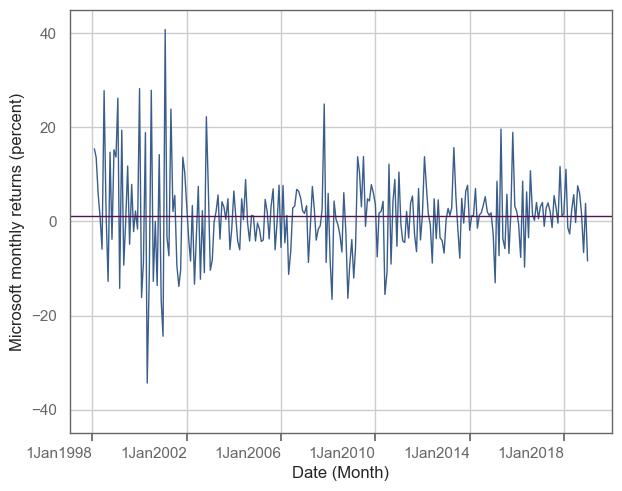

In [39]:
sns.lineplot(data=data_monthly, x="date", y="PctRetMSFT", linewidth=1)

plt.axhline(y=1.13, color=da.color[2], linewidth=1)
plt.xlabel("Date (Month)")
plt.ylabel("Microsoft monthly returns (percent)")

plt.xticks(breaks_sns, [pd.to_datetime(d).strftime("1%b%Y") for d in breaks_sns], ha="right")
plt.ylim(-45,45)
plt.yticks(ticks=np.arange(-40,41, 20))
plt.show()

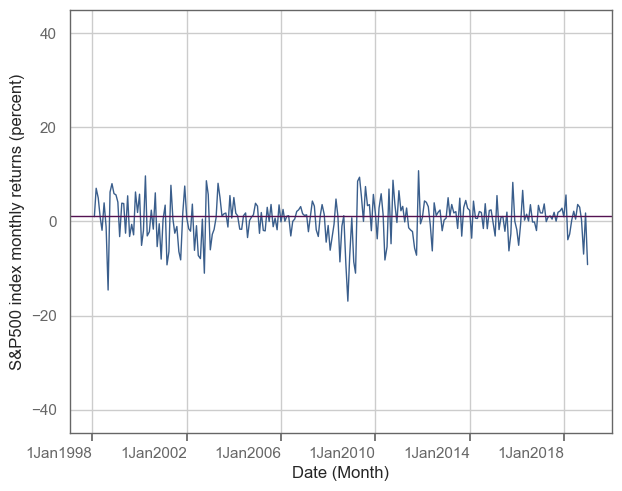

In [40]:
sns.lineplot(data=data_monthly, x="date", y="PctRetSP500", linewidth=1)

plt.axhline(y=1.13, color=da.color[2], linewidth=1)
plt.xlabel("Date (Month)")
plt.ylabel("S&P500 index monthly returns (percent)")

plt.xticks(breaks_sns, [pd.to_datetime(d).strftime("1%b%Y") for d in breaks_sns], ha="right")
plt.ylim(-45,45)
plt.yticks(ticks=np.arange(-40,41, 20))  
plt.show()

In [41]:
data_monthly.head(2)


,date,year,month,p_SP500,p_MSFT,l.p_MSFT,l.p_SP500,d.p_MSFT,d.p_SP500,PctRetMSFT,PctRetSP500,d.lnp_MSFT,d.lnp_SP500
0,1997-12-31,1997,12,970.429993,16.156250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1998-01-30,1998,1,980.280029,18.648438,16.15625,970.429993,2.492188,9.850036,15.425535,1.015018,0.143455,0.010099


In [42]:
print(
    PhillipsPerron(
        data_monthly.loc[1:, "PctRetMSFT"], lags=5, test_type="rho", trend="n"
    )
)
print(
    PhillipsPerron(
        data_monthly.loc[1:, "PctRetMSFT"], lags=5, test_type="rho", trend="c"
    )
)
print(
    PhillipsPerron(
        data_monthly.loc[1:, "PctRetMSFT"], lags=5, test_type="rho", trend="ct"
    )
)


     Phillips-Perron Test (Z-rho)    
Test Statistic               -285.235
P-value                         0.000
Lags                                5
-------------------------------------

Trend: No Trend
Critical Values: -12.12 (1%), -7.03 (5%), -4.96 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic               -280.444
P-value                         0.000
Lags                                5
-------------------------------------

Trend: Constant
Critical Values: -20.16 (1%), -13.86 (5%), -11.10 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic               -280.268
P-value                         0.000
Lags                                5
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -28.45 (1%),

In [43]:
print(
    PhillipsPerron(
        data_monthly.loc[1:, "PctRetSP500"], lags=5, test_type="rho", trend="n"
    )
)
print(
    PhillipsPerron(
        data_monthly.loc[1:, "PctRetSP500"], lags=5, test_type="rho", trend="c"
    )
)
print(
    PhillipsPerron(
        data_monthly.loc[1:, "PctRetSP500"], lags=5, test_type="rho", trend="ct"
    )
)


     Phillips-Perron Test (Z-rho)    
Test Statistic               -234.376
P-value                         0.000
Lags                                5
-------------------------------------

Trend: No Trend
Critical Values: -12.12 (1%), -7.03 (5%), -4.96 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic               -233.937
P-value                         0.000
Lags                                5
-------------------------------------

Trend: Constant
Critical Values: -20.16 (1%), -13.86 (5%), -11.10 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-rho)    
Test Statistic               -233.518
P-value                         0.000
Lags                                5
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -28.45 (1%),

### Table 12.1 Descriptive statistics on monthly returns

In [44]:
results = (
    data_monthly[["PctRetMSFT", "PctRetSP500"]]
    .describe()
    .T[["min", "max", "mean", "std", "count"]]
    .rename(columns={"std": "sd", "count": "N"})
)
results.index = ["Monthly returns on Microsoft (%)", "Monthly returns on S&P500 (%)"]
results.round(1)


,min,max,mean,sd,N
Monthly returns on Microsoft (%),-34.4,40.8,1.1,9.1,252.0
Monthly returns on S&P500 (%),-16.9,10.8,0.5,4.3,252.0


In [45]:
reg1 = pf.feols("PctRetMSFT ~ PctRetSP500", data=data_monthly, vcov="HC1")
reg2 = pf.feols(
    "d_lnp_MSFT ~ d_lnp_SP500",
    data=data_monthly.rename(
        columns={"d.lnp_MSFT": "d_lnp_MSFT", "d.lnp_SP500": "d_lnp_SP500"}
    ),
    vcov="HC1",
)
reg3 = pf.feols("PctRetMSFT ~ PctRetSP500", data=data_daily, vcov="HC1")
reg4 = pf.feols(
    "d_lnp_MSFT ~ d_lnp_SP500",
    data=data_daily.rename(
        columns={"d.lnp_MSFT": "d_lnp_MSFT", "d.lnp_SP500": "d_lnp_SP500"}
    ),
    vcov="HC1",
)

### Table 12.2 Returns on Microsoft and market returns: Simple regression results

In [46]:
pf.etable(
    [reg1],
    labels={
        "PctRetSP500": "S&P500 returns",
        "Intercept": "Constant",
    },
    model_heads=["Microsoft returns"],
    head_order="h",
    show_se_type=False,
    digits=2,
)

GT(_tbl_data=  level_0         level_1                    0
0    coef  S&P500 returns  1.26*** <br> (0.10)
1    coef        Constant     0.54 <br> (0.45)
2   stats    Observations                  252
3   stats   R<sup>2</sup>                 0.36, _body=<great_tables._gt_data.Body object at 0x0000027FB8F935C0>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000027FBC4A8410>, _spanners=Spanners([SpannerInfo(spanner_id='Microsoft returns', spanner_level=1, spanner_label='Microsoft returns', spanner_units=None, spanner_pattern=None, vars=['0'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000027FBC4A8260>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='hidden'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_color=OptionsInfo(scss=True, category='table', type='value', value='#D3

In [47]:
data_monthly["PctRetMSFT_rescaled"] = data_monthly["PctRetMSFT"] / 100

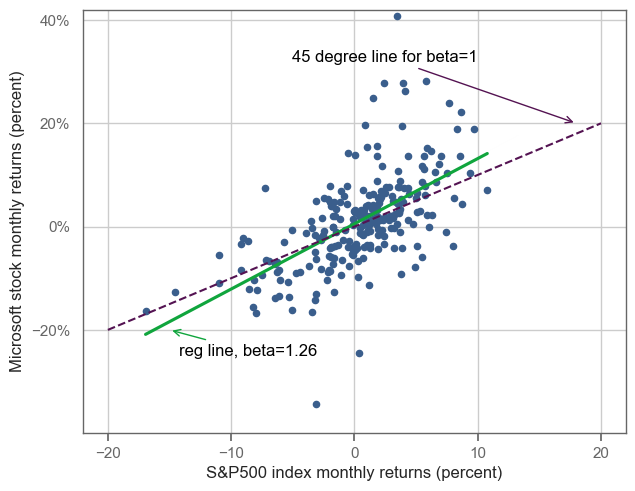

In [48]:
sns.regplot(data=data_monthly, x="PctRetSP500", y="PctRetMSFT_rescaled",ci=False,line_kws=dict(color=da.color[1]),scatter_kws=dict(alpha = 1,s = 20))
plt.plot([-20, 20], [-0.2, 0.2], linestyle="dashed", color=da.color[2])
plt.annotate(
    "45 degree line for beta=1",
    xy=(18,0.2), 
    xytext=(10, 0.32), 
    fontsize=12,
    ha="right",
    arrowprops=dict(color=da.color[2],arrowstyle="->")
)
plt.annotate(
    "reg line, beta=1.26",
    xy=(-15,-0.2), 
    xytext=(-3, -0.25), 
    fontsize=12,
    ha="right",
    arrowprops=dict(color=da.color[1],arrowstyle="->")
)
plt.xlabel("S&P500 index monthly returns (percent)", fontsize=12)
plt.ylabel("Microsoft stock monthly returns (percent)", fontsize=12)
plt.xlim(-22,22)
plt.xticks(np.arange(-20, 21, 10))  
plt.ylim(-0.4,0.42)
plt.yticks(np.arange(-0.2,0.4,0.2))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [49]:
data_monthly_tidy = pd.melt(
    data_monthly[["date", "PctRetMSFT", "PctRetSP500"]],
    id_vars=["date"],
    var_name="index",
    value_name="pct_return",
)
data_monthly_tidy["index"] = data_monthly_tidy["index"].replace({"PctRetMSFT": "Microsoft", "PctRetSP500": "S&P500"})

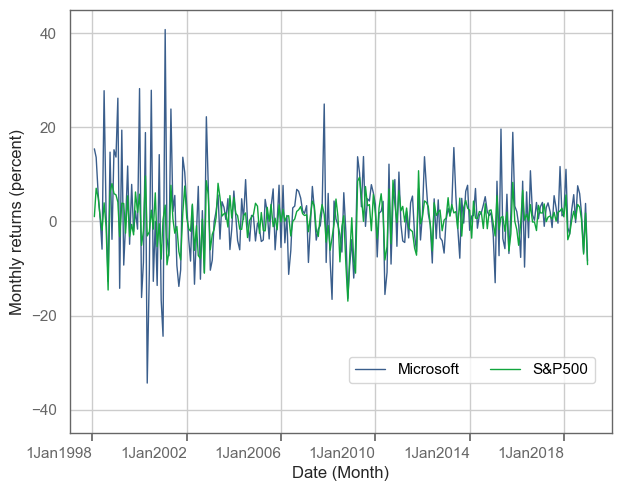

In [50]:
sns.lineplot(
    data=data_monthly_tidy,
    x="date",
    y="pct_return",
    hue="index",
    palette={"Microsoft": da.color[0], "S&P500": da.color[1]},
    linewidth=1
)
plt.legend(
    title=None, 
    loc="lower left", 
    bbox_to_anchor=(0.5, 0.1), 
    ncol=2
)
plt.xlabel("Date (Month)")
plt.ylabel("Monthly returns (percent)")
plt.xticks(breaks_sns, [pd.to_datetime(d).strftime("1%b%Y") for d in breaks_sns], ha="right")
plt.ylim(-45,45)
plt.yticks(ticks=np.arange(-40,41, 20))
plt.show()

In [51]:
data_monthly_tidy_17_18 = data_monthly_tidy.loc[
    data_monthly_tidy["date"] > "2017-01-01"
]

In [52]:
breaks_sns = [
    "2017-01-01", "2017-07-01", "2018-01-01",
    "2018-07-01", "2019-01-01"
]
breaks_sns = pd.to_datetime(breaks_sns)

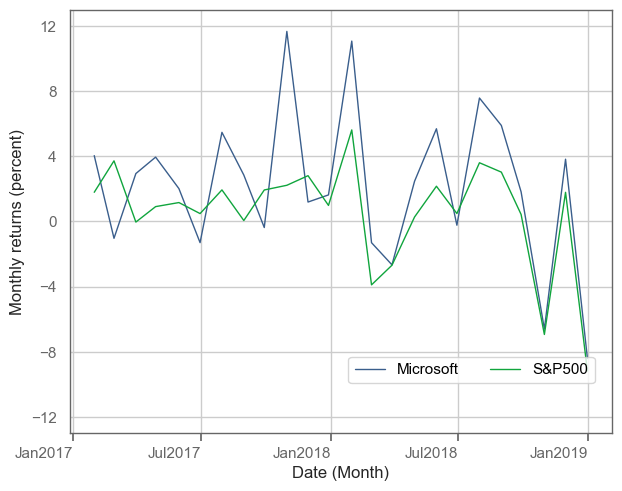

In [53]:
sns.lineplot(
    data=data_monthly_tidy_17_18,
    x="date",
    y="pct_return",
    hue="index",
    palette={"Microsoft": da.color[0], "S&P500": da.color[1]},
    linewidth=1
)
plt.legend(
    title=None, 
    loc="lower left", 
    bbox_to_anchor=(0.5, 0.1), 
    ncol=2
)
plt.xlabel("Date (Month)")
plt.ylabel("Monthly returns (percent)")
plt.xticks(breaks_sns, [pd.to_datetime(d).strftime("%b%Y") for d in breaks_sns], ha="right")
plt.ylim(-13,13)
plt.yticks(ticks=np.arange(-12,13, 4))
plt.show()

### Table 12.3 Returns on Microsoft and market returns: alternative measurements

In [54]:
pf.etable(
    [reg1, reg2, reg3, reg4],
    labels={
        "PctRetSP500": "S&P500 returns",
        "d_lnp_SP500": "S&P500 returns",
        "Intercept": "Constant",
    },
    model_heads=[
        "Monthly pct change",
        "Monthly log change",
        "Daily pct change",
        "Daily log change",
    ],
    head_order="h",
    show_se_type=False,
    digits=4,
)

GT(_tbl_data=  level_0         level_1                        0                        1  \
0    coef  S&P500 returns  1.2636*** <br> (0.1030)                            
1    coef  S&P500 returns                           1.2403*** <br> (0.1003)   
2    coef        Constant     0.5396 <br> (0.4529)     0.0026 <br> (0.0045)   
3   stats    Observations                      252                      252   
4   stats   R<sup>2</sup>                   0.3573                   0.3627   

                         2                        3  
0  1.1000*** <br> (0.0243)                           
1                           1.0951*** <br> (0.0236)  
2     0.0266 <br> (0.0202)     0.0002 <br> (0.0002)  
3                     5283                     5283  
4                   0.4492                   0.4465  , _body=<great_tables._gt_data.Body object at 0x0000027FB8E70F80>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='(4)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000027FBA607EF0>, _spanners=Spanners([SpannerInfo(spanner_id='Monthly pct change', spanner_level=1, spanner_label='Monthly pct change', spanner_units=None, spanner_pattern=None, vars=['0'], built=None), SpannerInfo(spanner_id='Monthly log change', spanner_level=1, spanner_label='Monthly log change', spanner_units=None, spanner_pattern=None, vars=['1'], built=None), SpannerInfo(spanner_id='Daily pct change', spanner_level=1, spanner_label='Daily pct change', spanner_units=None, spanner_pattern=None, vars=['2'], built=None), SpannerInfo(spanner_id='Daily log change', spanner_level=1, spanner_label='Daily log change', spanner_units=None, spanner_pattern=None, vars=['3'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000027FBA6044D0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_l